# 1次元の拡散モデルによる平均の推測

## モデルの定義(epoch30)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import time

start_time = time.time() # 計測開始

# Pytorchの組み込み演算により効率的に計算
# 高次元データ用のtorch.arrangeやtorch.expを活用してコードを簡潔に

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

## モデルの学習(epoch:30)

--------------------------------------------------
##################################################
Data_Set_1, Seed: 7270
Train Data Mean: 0.20807583703398852
Train Data Std: 0.9691809069790001
Train Data Shape: (50,)
Epoch 5, Loss: 0.6296895384788513
Epoch 10, Loss: 0.37274386584758756
Epoch 15, Loss: 0.359136700630188
Epoch 20, Loss: 0.18575666546821595
Epoch 25, Loss: 0.25219647884368895
Epoch 30, Loss: 0.19240680038928987
学習終了


学習時間: 13.24秒


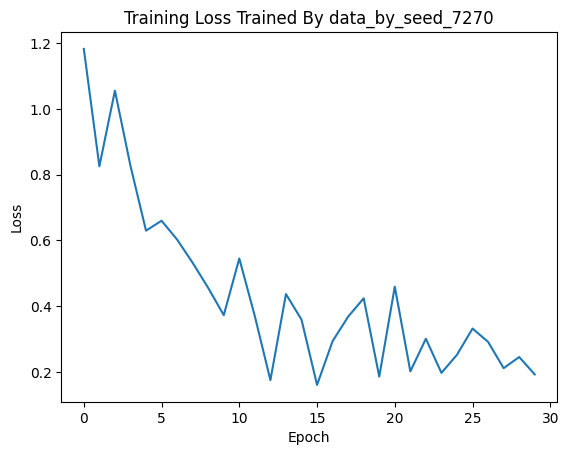



##################################################


--------------------------------------------------
##################################################
Data_Set_2, Seed: 860
Train Data Mean: -0.041345093554002475
Train Data Std: 0.9050458242431645
Train Data Shape: (50,)
Epoch 5, Loss: 0.8083842515945434
Epoch 10, Loss: 0.4925712436437607
Epoch 15, Loss: 0.3706285014748573
Epoch 20, Loss: 0.44377093240618704
Epoch 25, Loss: 0.40316439867019654
Epoch 30, Loss: 0.26728422939777374
学習終了


学習時間: 13.69秒


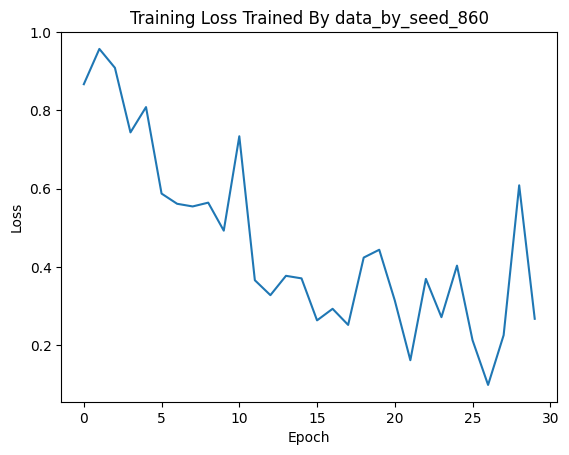



##################################################


--------------------------------------------------
##################################################
Data_Set_3, Seed: 5390
Train Data Mean: -0.13502767605681382
Train Data Std: 1.1281874792724071
Train Data Shape: (50,)
Epoch 5, Loss: 0.792412331700325
Epoch 10, Loss: 0.42715118229389193
Epoch 15, Loss: 0.679415724426508
Epoch 20, Loss: 0.4218319207429886
Epoch 25, Loss: 0.2048010155558586
Epoch 30, Loss: 0.32221866101026536
学習終了


学習時間: 14.11秒


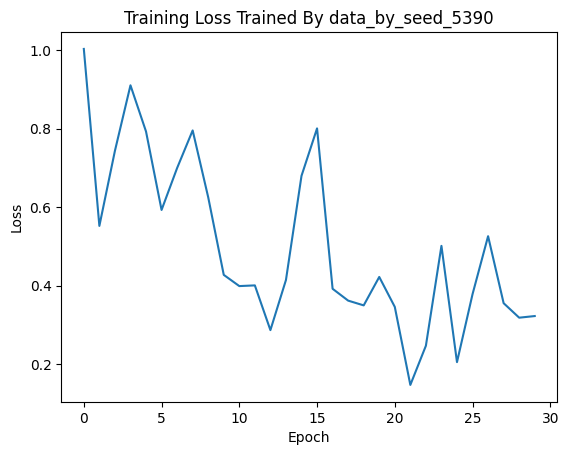



##################################################


--------------------------------------------------
##################################################
Data_Set_4, Seed: 5191
Train Data Mean: -0.11977299754915866
Train Data Std: 1.0691642557085834
Train Data Shape: (50,)
Epoch 5, Loss: 0.9019133627414704
Epoch 10, Loss: 0.5526418268680573
Epoch 15, Loss: 0.5866374969482422
Epoch 20, Loss: 0.41684112548828123
Epoch 25, Loss: 0.4391909509897232
Epoch 30, Loss: 0.31922935843467715
学習終了


学習時間: 14.53秒


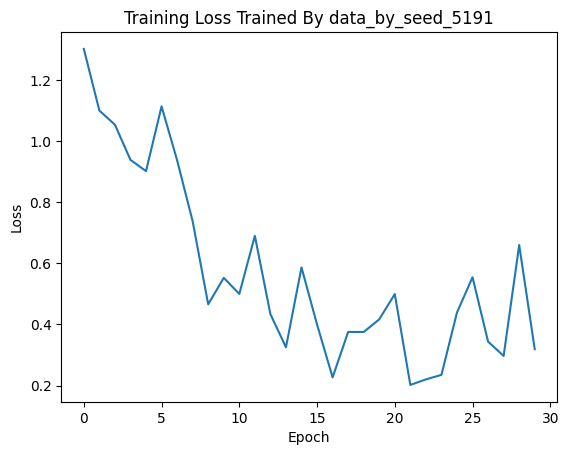



##################################################


--------------------------------------------------
##################################################
Data_Set_5, Seed: 5734
Train Data Mean: -0.012718415350903456
Train Data Std: 0.9813421048944091
Train Data Shape: (50,)
Epoch 5, Loss: 0.8279771208763123
Epoch 10, Loss: 0.5825456023216248
Epoch 15, Loss: 0.18609394431114196
Epoch 20, Loss: 0.4130593739449978
Epoch 25, Loss: 0.31213514804840087
Epoch 30, Loss: 0.17129023745656013
学習終了


学習時間: 14.96秒


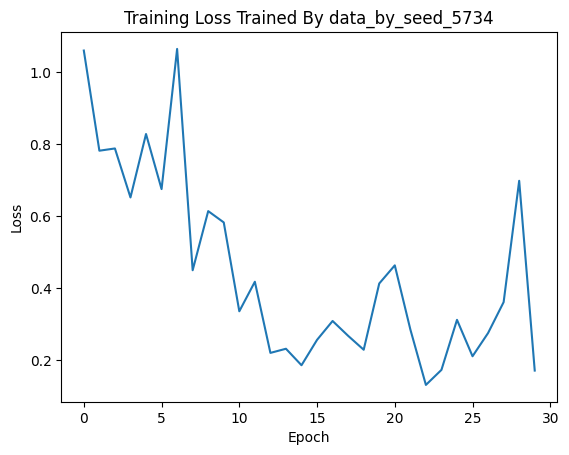



##################################################




In [ ]:
# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 30          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# シード値の固定
np.random.seed(42)

# サンプリング
iter = 5 #学習元データの数
# シード値の生成
random_seed = np.random.randint(0, 10000, iter)

# モデルとデータを管理する辞書
models = {}
datas = {}

for (i, seed) in enumerate(random_seed):
    print("-"*50)
    print("#"*50)
    print(f"Data_Set_{i+1}, Seed: {seed}")

    # モデルの初期化
    time_embed_dim = 16
    model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

    # 学習データ(ガウスノイズ)
    np.random.seed(seed)
    data = np.random.randn(50)  # shape: (50,)
    # scaler = StandardScaler()
    # data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    print("Train Data Mean:", data.mean())
    print("Train Data Std:", data.std())
    print("Train Data Shape:", data.shape)
    train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device)  # shape: (10, 1)

    # データローダー作成
    batch_size = 10
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 学習
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch.to(device)
            t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        avg_loss = loss_sum / len(dataloader)
        losses.append(avg_loss)
        # 5の倍数エポックで損失を表示
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # 辞書に保存
    models[f"model_{i+1}"] = model
    datas[f"seed_{seed}"] = data
    print("学習終了")
    end_time = time.time() # 計測終了
    print('\n')
    print(f"学習時間: {end_time - start_time:.2f}秒")

    # 学習曲線のプロット
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trained By data_by_seed_{}'.format(seed))
    plt.show()
    print('\n')
    print("#"*50)
    print('\n')

In [3]:
print(datas.keys())

dict_keys(['seed_7270', 'seed_860', 'seed_5390', 'seed_5191', 'seed_5734'])


## modelの保存

In [12]:
# モデルの保存
torch.save(models, 'models_dm_epo30.pth')
# データの保存
torch.save(datas, 'sample_datas_dm_epo30.pth')

## modelの参照

In [13]:
# モデルとデータの読み込み
models = torch.load('models_dm_epo30.pth')
datas = torch.load('sample_datas_dm_epo30.pth')

/tmp/ipykernel_11498/1394750674.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = torch.load('models_dm_epo30.pth')
/tmp/ipykernel_11498/1394750674.py:3: FutureWa

## サンプリング

サンプリング時間: 724.05秒
サンプリング時間: 12.0分 4.053846836090088秒
############################################


/home/simada/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


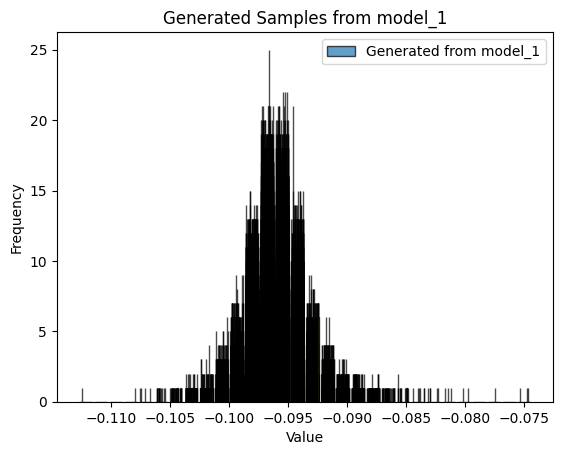

In [ ]:
# 結果の可視化
import matplotlib.pyplot as plt

# 生成に使用するモデルを選択
model_key = "model_1"  # 例として "dataset_0" のモデルを使用
selected_model = models[model_key]  # 辞書からモデルを取得

# 拡散モデルのサンプリング関数
def generate_samples(model, n=50, B=1000, device='cpu'):
    # n: 1データセットあたりのサンプル数
    # B: データセットの数
    model.eval()  # 評価モードに設定
    with torch.no_grad():
        new_sample_list = []
        for _ in range(B):
            torch.manual_seed(np.random.randint(0, 10000)) # シード値の固定
            samples = torch.randn((n, 1), device=device)
            for t in range(num_timesteps, 0, -1):
                t_tensor = torch.tensor([t] * len(samples), device=device)
                samples = diffuser.denoise(model, samples, t_tensor)
            samples = samples.view(n).cpu().numpy()
            new_sample_list.append(samples) # サンプルをリストに追加
    return new_sample_list

start_time = time.time() # 計測開始
# サンプリング実行
generated_data = generate_samples(selected_model, n=50, B=1000, device=device)
end_time = time.time() # 計測終了

print(f"サンプリング時間: {end_time - start_time:.2f}秒")
print(f"サンプリング時間: {(end_time - start_time)//60}分 {(end_time - start_time)%60}秒")
print("############################################")



plt.hist(generated_data, bins=30, alpha=0.7, edgecolor='black', label=f"Generated from {model_key}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Generated Samples from {model_key}")
plt.legend()
plt.show()

## サンプリング

In [7]:
# 結果の可視化
import matplotlib.pyplot as plt

# # 生成に使用するモデルを選択
# model_key = "model_1"  # 例として "dataset_0" のモデルを使用
# selected_model = models[model_key]  # 辞書からモデルを取得

# 拡散モデルのサンプリング関数
def generate_samples(model, n=50, B=1000, device='cpu'):
    # n: 1データセットあたりのサンプル数
    # B: データセットの数
    model.eval()  # 評価モードに設定
    with torch.no_grad():
        new_sample_list = []
        for _ in range(B):
            torch.manual_seed(np.random.randint(0, 10000)) # シード値の固定
            samples = torch.randn((n, 1), device=device)
            for t in range(num_timesteps, 0, -1):
                t_tensor = torch.tensor([t] * len(samples), device=device)
                samples = diffuser.denoise(model, samples, t_tensor)
            samples = samples.view(n).cpu().numpy()
            new_sample_list.append(samples) # サンプルをリストに追加
    return new_sample_list

generated_data_list = []

for model_key, data, seed, selected_model in zip(datas.keys(), datas.values(), models.keys(), models.values()):
    print("-"*50)
    print("#"*50)
    print(f"Seed: {seed.split('_')[-1]}")
    print("サンプリング開始")

    start_time = time.time() # 計測開始
    generated_data = generate_samples(selected_model, n=50, B=1000, device=device) # サンプリング実行
    generated_data_list.append(generated_data) # サンプルをリストに追加
    end_time = time.time() # 計測終了
    print("サンプリング終了")

    print(f"サンプリング時間: {end_time - start_time:.2f}秒")
    print(f"サンプリング時間: {(end_time - start_time)//60}分 {(end_time - start_time)%60}秒")
    print("#"*50)



--------------------------------------------------
##################################################
Seed: 1
サンプリング開始
サンプリング終了
サンプリング時間: 714.26秒
サンプリング時間: 11.0分 54.255362033843994秒
##################################################
--------------------------------------------------
##################################################
Seed: 2
サンプリング開始
サンプリング終了
サンプリング時間: 734.03秒
サンプリング時間: 12.0分 14.034695148468018秒
##################################################
--------------------------------------------------
##################################################
Seed: 3
サンプリング開始
サンプリング終了
サンプリング時間: 741.10秒
サンプリング時間: 12.0分 21.097167015075684秒
##################################################
--------------------------------------------------
##################################################
Seed: 4
サンプリング開始
サンプリング終了
サンプリング時間: 738.65秒
サンプリング時間: 12.0分 18.650370121002197秒
##################################################
--------------------------------------------------
#################

### 学習元データをヒストグラムに描画

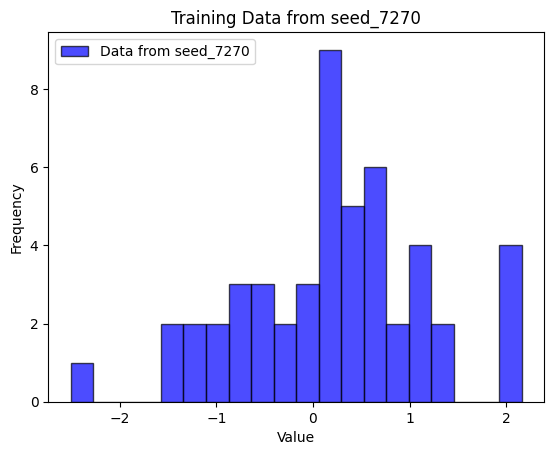

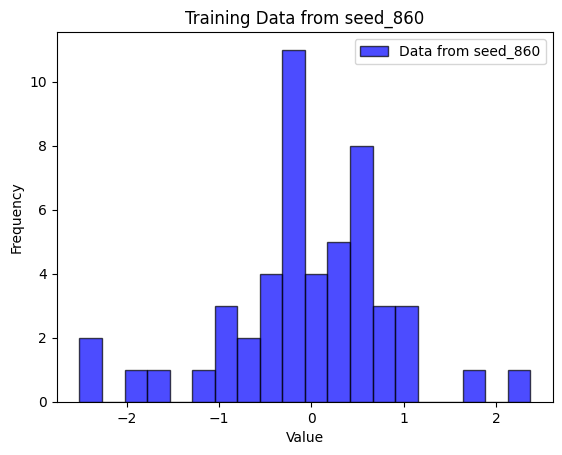

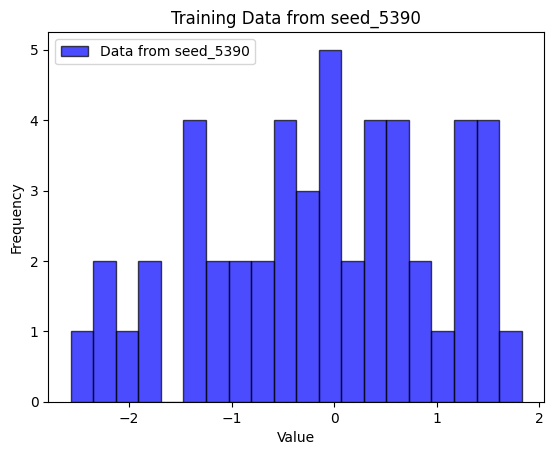

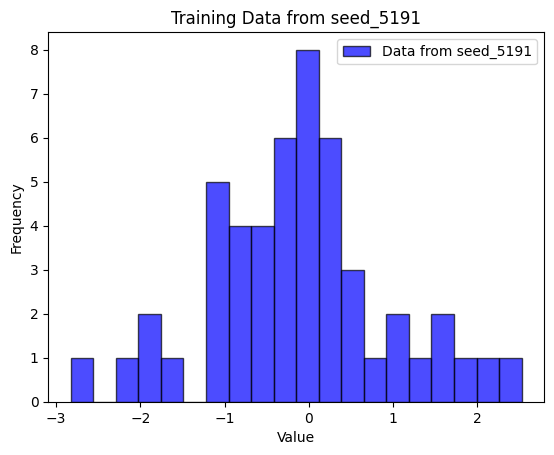

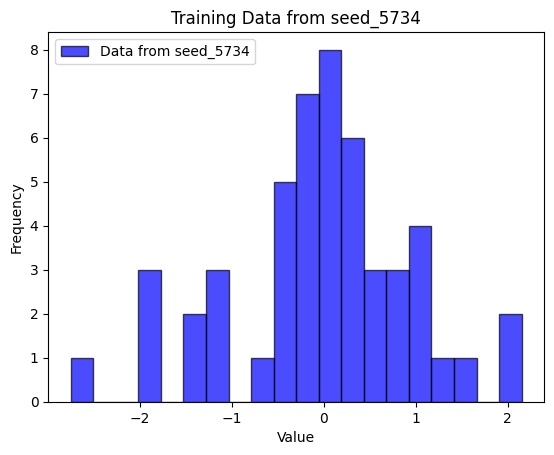

In [8]:
for seed, data in zip(datas.keys(), datas.values()):
    # dataのヒストグラムのプロット
    plt.hist(data, bins=20, alpha=0.7, color='blue', edgecolor='black', label=f"Data from seed_{seed.split('_')[-1]}" )
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Training Data from seed_{seed.split('_')[-1]}")
    plt.legend()
    plt.show()

### 生成されたデータセットごとに平均とってヒストグラムに描画

generated_data_mean Shape: (1000,)


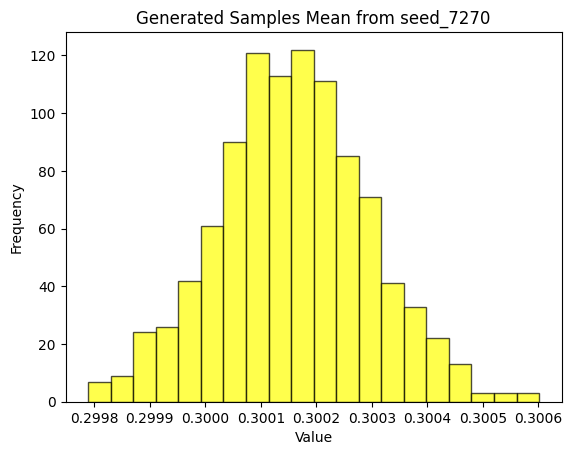

generated_data_mean Shape: (1000,)


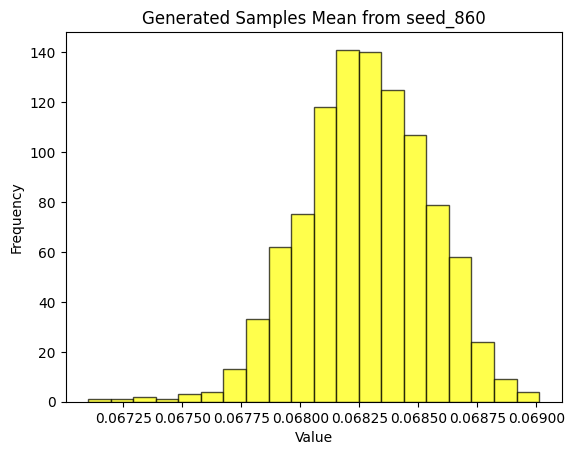

generated_data_mean Shape: (1000,)


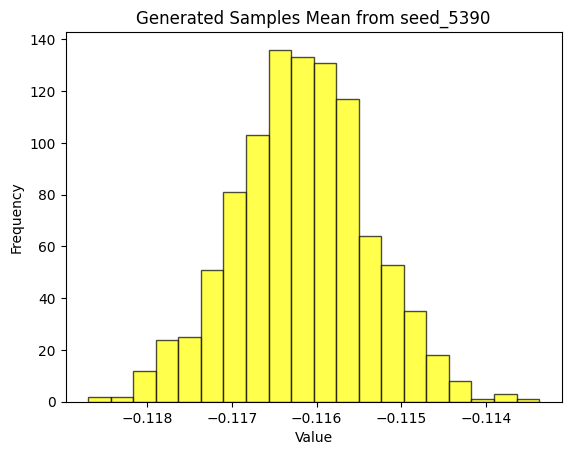

generated_data_mean Shape: (1000,)


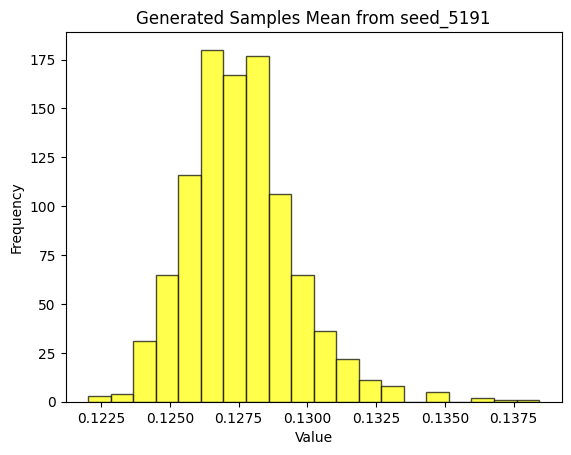

generated_data_mean Shape: (1000,)


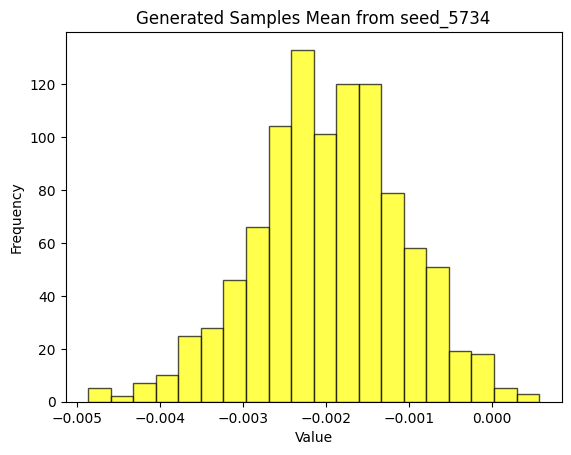

In [9]:
generated_data_mean_list = []
# 生成データの平均を求める
# ヒストグラムプロット
for generated_data, seed in zip(generated_data_list, datas.keys()):
    generated_data_mean = np.mean(generated_data, axis=1) # 生成データそれぞれ平均を求める
    generated_data_mean_list.append(generated_data_mean) # 平均をリストに追加
    print("generated_data_mean Shape:",generated_data_mean.shape) # サイズの確認
    # 平均のヒストグラムのプロット
    plt.hist(generated_data_mean, bins=20, alpha=0.7, color='yellow', edgecolor='black', label=f"Generated from {seed}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Generated Samples Mean from {seed}")
    plt.show()

### 元データとサンプリングデータセットごと平均の平均と分散の比較

In [10]:
import statistics
# サンプルデータセットごとの平均と分散を求める
for generated_data_mean, seed, data in zip(generated_data_mean_list, datas.keys(), datas.values()):
    print("-"*50)
    print("#"*50)
    print(f"Seed: {seed.split('_')[-1]}")
    print("Original_Data Mean:", statistics.mean(data))
    print("Original_Data Variance:", statistics.pvariance(data))
    print("generated_data Mean:", statistics.mean(generated_data_mean))
    print("generated_data Variance:", statistics.pvariance(generated_data_mean))
    print("#"*50)

--------------------------------------------------
##################################################
Seed: 7270
Original_Data Mean: 0.20807583703398855
Original_Data Variance: 0.9393116304526372
generated_data Mean: 0.300159
generated_data Variance: 1.865808e-08
##################################################
--------------------------------------------------
##################################################
Seed: 860
Original_Data Mean: -0.04134509355400248
Original_Data Variance: 0.819107943979989
generated_data Mean: 0.06827814
generated_data Variance: 7.036458e-08
##################################################
--------------------------------------------------
##################################################
Seed: 5390
Original_Data Mean: -0.13502767605681382
Original_Data Variance: 1.272806988387028
generated_data Mean: -0.11617209
generated_data Variance: 6.215798e-07
##################################################
--------------------------------------------------


In [ ]:
# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 30          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# シード値の固定
np.random.seed(42)

# サンプリング
iter = 5 #学習元データの数
# シード値の生成
random_seed = np.random.randint(0, 10000, iter)

# モデルとデータを管理する辞書
models = {}
datas = {}

for (i, seed) in enumerate(random_seed):
    print("-"*50)
    print("#"*50)
    print(f"Data_Set_{i+1}, Seed: {seed}")

    # モデルの初期化
    time_embed_dim = 16
    model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

    # 学習データ(ガウスノイズ)
    np.random.seed(seed)
    data = np.random.randn(50)  # shape: (50,)
    # scaler = StandardScaler()
    # data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    print("Train Data Mean:", data.mean())
    print("Train Data Std:", data.std())
    print("Train Data Shape:", data.shape)
    train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device)  # shape: (10, 1)

    # データローダー作成
    batch_size = 10
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 学習
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch.to(device)
            t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        avg_loss = loss_sum / len(dataloader)
        losses.append(avg_loss)
        # 5の倍数エポックで損失を表示
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # 辞書に保存
    models[f"model_{i+1}"] = model
    datas[f"seed_{seed}"] = data
    print("学習終了")
    end_time = time.time() # 計測終了
    print('\n')
    print(f"学習時間: {end_time - start_time:.2f}秒")

    # 学習曲線のプロット
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trained By data_by_seed_{}'.format(seed))
    plt.show()
    print('\n')
    print("#"*50)
    print('\n')

# アーカイブ

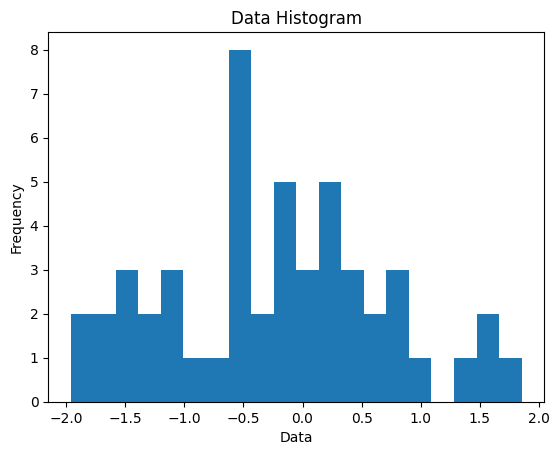

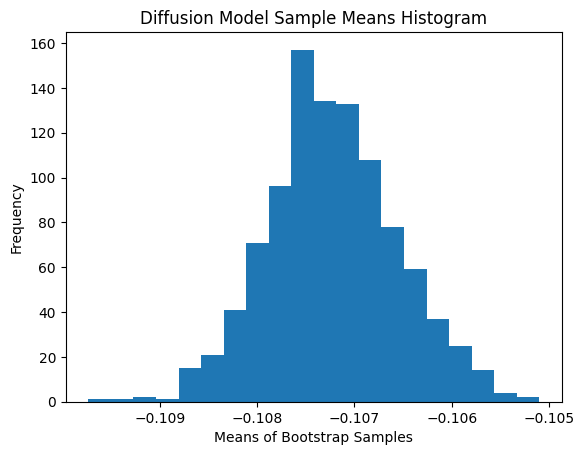

In [6]:
# 元データのヒストグラム
plt.hist(data, bins=20)
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('Data Histogram')
plt.show()

# sample_listのヒストグラム
plt.hist(new_sample_list_mean, bins=20)
plt.xlabel('Means of Bootstrap Samples')
plt.ylabel('Frequency')
plt.title('Diffusion Model Sample Means Histogram')
plt.show()


In [8]:
import statistics
# もとデータの平均
print("Original_Data Mean", statistics.mean(data))
# もとデータの分散
print("Original_Data Variance", statistics.pvariance(data))
# 標本平均
print("sampled_data Mean", statistics.mean(new_sample_list_mean))
# 標本分散  
print("sampled_data Variance", statistics.pvariance(new_sample_list_mean))

Original_Data Mean -0.22547390525614008
Original_Data Variance 0.8543026463778314
sampled_data Mean -0.107220575
sampled_data Variance 4.3440212e-07


In [9]:
print('data', data)
# もとデータの平均
print("Original Data", statistics.mean(data))
# もとデータの分散
print("Original Data", statistics.pvariance(data))

data [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
 -0.11564828 -0.3011037  -1.47852199 -0.71984421 -0.46063877  1.05712223
  0.34361829 -1.76304016]
Original Data -0.22547390525614008
Original Data 0.8543026463778314
